<a href="https://colab.research.google.com/github/HagarIbrahiem/Time-Series-Analysis-Forecasting/blob/main/1_ExploringDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs & APIs

In [ ]:
!pip install gdown

## Load Data

In [ ]:
# https://drive.google.com/file/d/1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4/view?usp=sharing

import gdown

# Google Drive file ID
file_id = '1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4'

# Create the download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file
gdown.download(url, 'sales_data.parquet.gzip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4
From (redirected): https://drive.google.com/uc?export=download&id=1o8LO0br8RMQ0B0Wu43RrTN9LiBvutd_4&confirm=t&uuid=cd7e142c-1394-435a-8caf-1d009532836a
To: /kaggle/working/sales_data.parquet.gzip
100%|██████████| 698M/698M [00:03<00:00, 193MB/s] 


'sales_data.parquet.gzip'

In [ ]:
import pandas as pd

# Read the .gzip Parquet file into a DataFrame
_df = pd.read_parquet('sales_data.parquet.gzip')

# Check the data
_df.head()


,latitude,longitude,timestamp,product_id,quantity,total_amount
0,23.669917,-97.455367,2023-10-05,1006,1.0,84.35
1,23.659791,-97.396217,2023-10-05,1172,2.0,198.84
2,23.674743,-97.357560,2023-10-05,1192,12.0,2706.72
3,23.718871,-97.196633,2023-10-05,1246,1.0,332.16
4,18.965386,-86.610368,2023-10-05,27,1.0,16.08


In [ ]:
df= _df.copy()

##  Data Validation

In [ ]:
df.shape

(127183326, 6)

In [ ]:
# Check the data type of the 'timestamp' column
print(df['timestamp'].dtype)

datetime64[ns]


In [ ]:
# Get the minimum and maximum timestamp in awhole dataset
min_timestamp = df['timestamp'].min()
max_timestamp = df['timestamp'].max()

print("Minimum Timestamp:", min_timestamp)
print("Maximum Timestamp:", max_timestamp)


Minimum Timestamp: 2023-10-05 00:00:00
Maximum Timestamp: 2024-08-21 23:59:00


In [ ]:
# Check for missing values
df.isnull().sum()

latitude              0
longitude             0
timestamp             0
product_id            0
quantity        6345474
total_amount    6345474
dtype: int64

In [ ]:
#Check the Timestamp Distribution of Missing Data
# Filter rows with missing quantity or total_amount
missing_data = df[df['quantity'].isnull() | df['total_amount'].isnull()]
missing_min = missing_data['timestamp'].min()
missing_max = missing_data['timestamp'].max()

print(f"Missing data ranges from {missing_min} to {missing_max}")


Missing data ranges from 2023-10-05 00:01:00 to 2024-08-21 23:59:00


In [ ]:
# Count missing records per day
missing_by_day = missing_data['timestamp'].dt.date.value_counts().sort_index()

# Display
print(missing_by_day)


timestamp
2023-10-05     2983
2023-10-06     3123
2023-10-07     3234
2023-10-08     2299
2023-10-09     2580
              ...  
2024-08-17    37976
2024-08-18    30780
2024-08-19    28826
2024-08-20    29787
2024-08-21    30416
Name: count, Length: 298, dtype: int64


In [ ]:
#Check if missingness is tied to specific products
missing_data['product_id'].value_counts().head(10)

product_id
27      674838
1236    185326
1001    147361
1006    139666
1029    131477
1016    122651
23      120069
258     112904
896      99978
24       98657
Name: count, dtype: int64

In [ ]:
# Top products in entire dataset (not just missing)
df['product_id'].value_counts().head(10)

product_id
27      13529117
1236     3720349
1001     2956733
1006     2781964
1029     2638697
1016     2448181
23       2407371
258      2265529
896      2005767
24       1977944
Name: count, dtype: int64

In [ ]:
#Check if it's tied to specific stores (lat/lon)
missing_data.groupby(['latitude', 'longitude']).size().sort_values(ascending=False).head(10)


latitude   longitude  
19.138962  -83.769004     11256
30.477621  -113.927027     9667
29.895531  -113.698180     9379
23.648110  -97.329739      9152
23.650836  -97.334512      9028
23.691723  -97.326525      8681
23.714670  -97.272871      8654
23.709781  -97.347208      8563
30.341738  -114.057171     8561
23.689374  -97.351897      8546
dtype: int64

**let's visualize geographic distribution of missingness**

In [ ]:
# Filter missing rows
missing_data = df[df['quantity'].isnull() | df['total_amount'].isnull()]

# Group by latitude and longitude, count occurrences
missing_location_counts = (
    missing_data.groupby(['latitude', 'longitude'])
    .size()
    .reset_index(name='missing_count')
)

import folium
from folium.plugins import HeatMap

# Center of the map
map_center = [missing_location_counts['latitude'].mean(), missing_location_counts['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Add heatmap
heat_data = [[row['latitude'], row['longitude'], row['missing_count']] for _, row in missing_location_counts.iterrows()]
HeatMap(heat_data, radius=18).add_to(m)

m  # Show map


Please find the attached screenshot of the map, as it is not displaying correctly on GitHub.

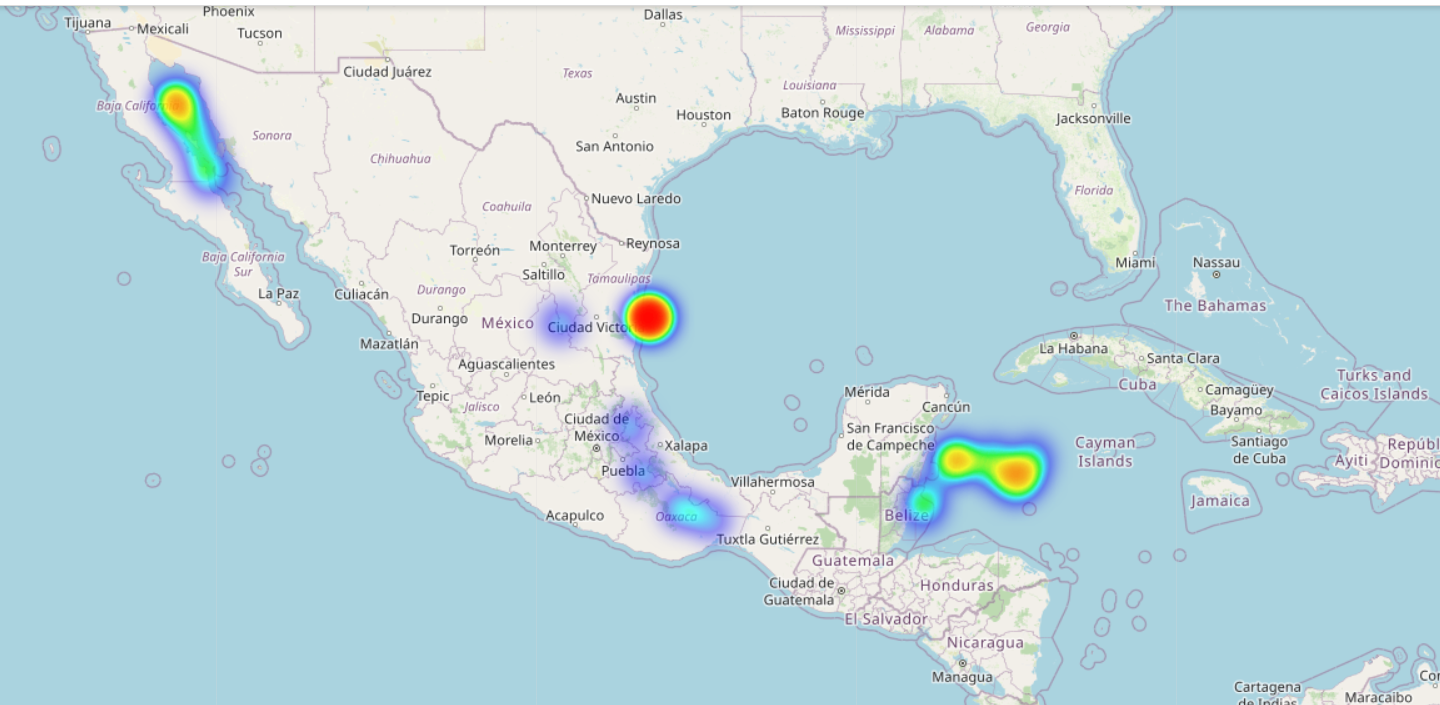

✅ Quick Summary of Data Quality
- Rows: ~127M records.
- Missing values: quantity and total_amount each have 6.3M missing entries (~5% of the data).
- Timestamps range from 2023-10-05 to 2024-08-21, so we’ve got ~10.5 months of data.

✅ Missing Data is Spread Across the Entire Time Range
- First date of missing values: 2023-10-05
- Last date of missing values: 2024-08-21
    
This matches exactly with the full dataset's time range, which implies:
- The missing sales data is not isolated to any short timeframe.
- This is likely a systematic issue, possibly intermittent data loss or unlogged values across the full period.

📊 Missing Volume Appears to Increase Over Time
- Early dates (Oct 2023) have ~2K–3K missing rows/day.
- Later dates (Aug 2024) have ~30K–38K missing rows/day.
  
This could indicate:
- Growth in data volume over time — more stores or transactions later in the year.
- A deteriorating logging pipeline — later periods may have more recording failures.

🔍 Interpretation of missing values (**products**)
- Product 27 alone is responsible for ~10% of all missing values (674k out of 6.3M)!
- The top 3–5 products likely contribute the majority of missing rows.
- These may represent frequently sold products where data corruption is more likely.
- The missing data ratio is very consistent (~5%) across all major & top products across the dataset.
- This strongly suggests that the missing entries are systematic and uniform, rather than caused by specific product issues.
- Most likely root cause: a consistent logging issue or ETL bug across the board rather than isolated product problems.

🔍 Interpretation of missing values (**stores**)
- The first location (19.138962, -83.769004) has ~11.2K missing entries, making it the most affected.
- Most of the others are clustered around 23.6 to 23.7° latitude and -97.3° longitude, likely representing a group of nearby stores — possibly the same city or chain location.
- This could mean:
  
     - Store-level logging issues, e.g., faulty POS systems.
     - Regional network disruptions (especially if many stores are clustered in one area).

💡 **Conclusion**

Missing data occurs uniformly over time and across top products. It'sikely systemic issue, not tied to specific dates, stores, or items. Thus we can **safely drop missing rows** for trend analysis, as they appear random and proportionally distributed.